In [1]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Tue Jan 10 07:05:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
%pwd

'/kaggle/working'

# 1. 데이터 불러오기

In [5]:
data_dir = '../input/hotdognothotdog'

In [6]:
!ls ../input/

hotdognothotdog


In [7]:
# transform = transforms.Compose([transforms.ToTensor()]) # 299, 299 추청

In [8]:
transform = transforms.Compose([transforms.Resize([299, 299]), transforms.ToTensor()])

In [9]:
trainset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/train', transform=transform)
testset = datasets.ImageFolder(root= data_dir + '/hotdog-nothotdog/test', transform=transform)

In [10]:
trainset, validset = random_split(trainset, [2500, 500])

In [11]:
print(type(trainset), len(trainset)) 
print(type(validset), len(validset))
print(type(testset), len(testset))

<class 'torch.utils.data.dataset.Subset'> 2500
<class 'torch.utils.data.dataset.Subset'> 500
<class 'torchvision.datasets.folder.ImageFolder'> 644


In [12]:
print(type(trainset[0][0]), type(trainset[0][1]))  

<class 'torch.Tensor'> <class 'int'>


# 2. 데이터 시각화

In [13]:
# 0번째 샘플 이미지
trainset[0][0].size(), trainset[0][1]

(torch.Size([3, 299, 299]), 0)

In [14]:
# 1번 샘플
sample_img = trainset[1][0]
sample_img.size()

torch.Size([3, 299, 299])

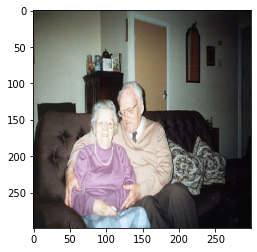

In [15]:
plt.imshow(sample_img.permute(1, 2, 0))

In [16]:
sample_img.size()

torch.Size([3, 299, 299])

In [17]:
numpy_sample = sample_img.numpy()
numpy_sample.shape

(3, 299, 299)

In [18]:
type(numpy_sample)

numpy.ndarray

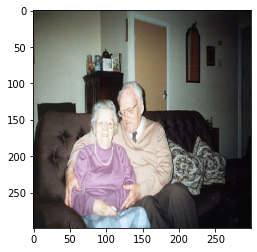

In [19]:
plt.imshow(numpy_sample.transpose(1, 2, 0))

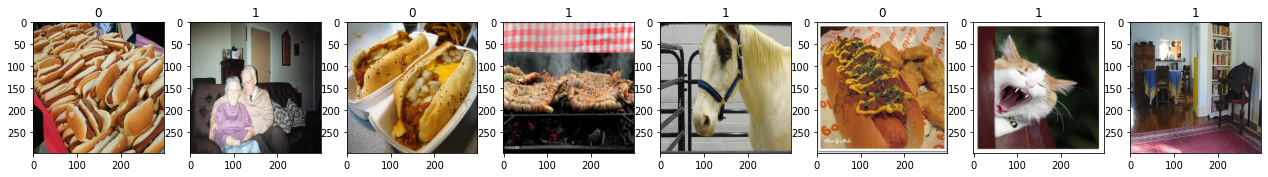

In [20]:
figure, axes = plt.subplots(nrows=1, ncols=8, figsize=(22, 6))
for i in range(8):
    axes[i].imshow(trainset[i][0].permute(1, 2, 0))
    axes[i].set_title(trainset[i][1])   

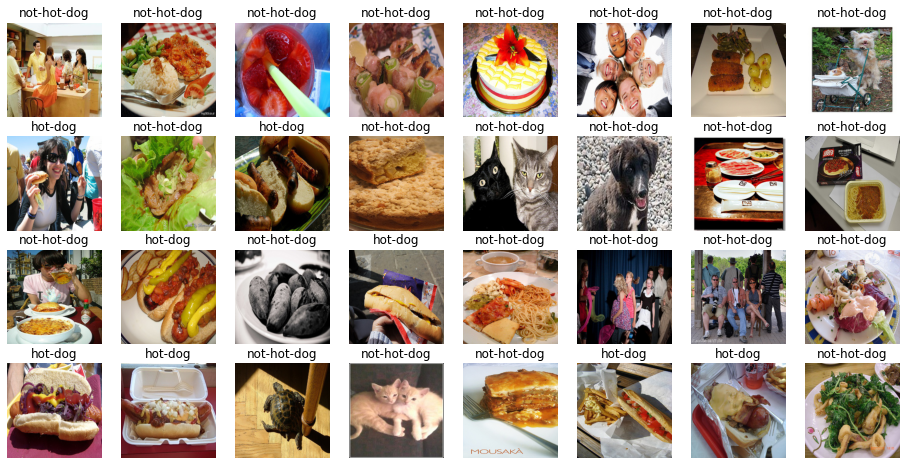

In [21]:
labels_map = {0 : 'hot-dog', 1 : 'not-hot-dog'}  

figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(trainset))
    image = trainset[rand_i][0].permute(1, 2, 0)
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(labels_map[trainset[rand_i][1]])   

# 3. 데이터 적재

In [23]:
batch_size = 32 # 16에서 32로 변경
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용

In [24]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 79
<class 'torch.utils.data.dataloader.DataLoader'> 16
<class 'torch.utils.data.dataloader.DataLoader'> 21


In [25]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
print(images.size(), labels.size())

torch.Size([32, 3, 299, 299]) torch.Size([32])


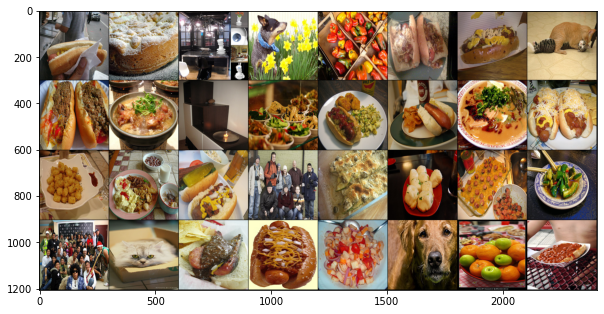

In [26]:
gird_img = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 100))
plt.imshow(gird_img.permute(1, 2, 0))

# 4. 모델생성

In [27]:
from torch import nn 
from torch import optim 
import torch.nn.functional as F 

In [28]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')

tensor([[ 0.9131,  0.5393,  0.7422,  0.7265, -0.1408],
        [-1.0213, -1.1832,  0.1070, -0.3906, -0.7136],
        [ 1.0912, -0.1228,  0.4631, -1.1995,  0.7014]])

In [29]:
import math
b = torch.empty(3)
bound = 1 / math.sqrt(w.size(1))
nn.init.uniform_(b, -bound, bound)

tensor([ 0.1518, -0.3048,  0.2466])

In [30]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # 1st block
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 96 x 149 x 149
            # 2nd block
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 74 x 74
            # 3rd block
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 37 x 37
            # 4rd block
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 256 x 18 x 18
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features=256*18*18, out_features=1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=1024, out_features=512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=2)    
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*18*18)  # flatten
        x = self.classifier(x)
        return x

In [31]:
model = AlexNet()
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [32]:
for parameter in model.parameters():
    print(parameter.size())

torch.Size([96, 3, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([96])
torch.Size([256, 96, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([384, 256, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([384, 384, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([384, 256, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([384, 384, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([1024, 82944])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([2, 512])
torch.Size([2])


In [33]:
for name, parameter in model.named_parameters():
    print(name, parameter.size())

features.0.weight torch.Size([96, 3, 3, 3])
features.0.bias torch.Size([96])
features.1.weight torch.Size([96])
features.1.bias torch.Size([96])
features.4.weight torch.Size([256, 96, 3, 3])
features.4.bias torch.Size([256])
features.5.weight torch.Size([256])
features.5.bias torch.Size([256])
features.8.weight torch.Size([384, 256, 3, 3])
features.8.bias torch.Size([384])
features.9.weight torch.Size([384])
features.9.bias torch.Size([384])
features.11.weight torch.Size([384, 384, 3, 3])
features.11.bias torch.Size([384])
features.12.weight torch.Size([384])
features.12.bias torch.Size([384])
features.14.weight torch.Size([256, 384, 3, 3])
features.14.bias torch.Size([256])
features.15.weight torch.Size([256])
features.15.bias torch.Size([256])
features.18.weight torch.Size([384, 256, 3, 3])
features.18.bias torch.Size([384])
features.19.weight torch.Size([384])
features.19.bias torch.Size([384])
features.21.weight torch.Size([384, 384, 3, 3])
features.21.bias torch.Size([384])
featur

In [34]:
!pip install torchsummary

In [35]:
from torchsummary import summary

In [36]:
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 299, 299]           2,688
       BatchNorm2d-2         [-1, 96, 299, 299]             192
              ReLU-3         [-1, 96, 299, 299]               0
         MaxPool2d-4         [-1, 96, 149, 149]               0
            Conv2d-5        [-1, 256, 149, 149]         221,440
       BatchNorm2d-6        [-1, 256, 149, 149]             512
              ReLU-7        [-1, 256, 149, 149]               0
         MaxPool2d-8          [-1, 256, 74, 74]               0
            Conv2d-9          [-1, 384, 74, 74]         885,120
      BatchNorm2d-10          [-1, 384, 74, 74]             768
             ReLU-11          [-1, 384, 74, 74]               0
           Conv2d-12          [-1, 384, 74, 74]       1,327,488
      BatchNorm2d-13          [-1, 384, 74, 74]             768
             ReLU-14          [-1, 384,

# 5. 모델 컴파일

In [37]:
learning_rate = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [38]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)

# 6. 모델훈련(with 검증)

In [39]:
def validation(model, validloader, criterion):
    valid_accuracy = 0
    valid_loss = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) # 점수 반환
            _, preds = torch.max(logits, 1) 
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) 
      
            valid_accuracy += accuracy
            valid_loss += loss.item() # tensor 값을 꺼내옴
    

    return valid_loss, valid_accuracy 

In [40]:
from torch.utils.tensorboard import SummaryWriter
writer  = SummaryWriter()

In [41]:
train_loss_list = []
valid_loss_list = []
valid_acc_list = []


def train(model, epochs, criterion, optimizer):
    steps = 0
    min_loss = 10000
    max_accuracy = 0
    trigger = 0
    patience = 5 # for Early stopping
    
    # 1 에폭(epoch)당 반복수
    #steps_per_epoch = len(trainset)/batch_size # 31.125iterations
    steps_per_epoch = len(trainloader) # 31.125 iterations

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in iter(trainloader):
            steps += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images) # 예측
            loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환
            optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
            loss.backward()
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0:
                model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
                valid_loss, valid_accuracy = validation(model, validloader, criterion)

                # 시각화
                train_loss_list.append(train_loss/len(trainloader))
                valid_loss_list.append(valid_loss/len(validloader))
                valid_acc_list.append(valid_accuracy/len(validloader))
                # tensorboard
                writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
                writer.add_scalars("Loss/train and valid",
                                  {'train' : train_loss/len(trainloader),
                                   'valid' : valid_loss/len(validloader)}, epoch)
        
                writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)


                print('Epoch : {}/{}.....'.format(epoch+1, epochs),
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
        
                # Best model 저장
                if valid_accuracy > max_accuracy: 
                    max_accuracy = valid_accuracy
                    torch.save(model.state_dict(), 'best_checkpoint.pth')

                # Early Stopping 
                if valid_loss > min_loss:
                    trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
                    print('trigger : ', trigger )
                    if trigger > patience:
                        print('Early Stopping!!!')
                        print('Traning step is finished!!')
                        writer.flush()  
                        return   
                    else:
                        trigger = 0
                        min_loss = valid_loss

                    train_loss = 0
                    model.train()
                    # Learning Rate Scheduler
                    scheduler.step(valid_loss)
        writer.flush()      

In [42]:
epochs=30
train(model, epochs, criterion, optimizer)

Epoch : 1/30..... Train Loss : 0.621 Valid Loss : 0.547 Valid Accuracy : 0.720
Epoch : 2/30..... Train Loss : 0.466 Valid Loss : 0.541 Valid Accuracy : 0.714
Epoch : 3/30..... Train Loss : 0.379 Valid Loss : 0.550 Valid Accuracy : 0.715
Epoch : 4/30..... Train Loss : 0.308 Valid Loss : 0.490 Valid Accuracy : 0.773
Epoch : 5/30..... Train Loss : 0.246 Valid Loss : 0.493 Valid Accuracy : 0.791
Epoch : 6/30..... Train Loss : 0.199 Valid Loss : 0.639 Valid Accuracy : 0.723
Epoch : 7/30..... Train Loss : 0.156 Valid Loss : 0.492 Valid Accuracy : 0.772
Epoch : 8/30..... Train Loss : 0.115 Valid Loss : 0.518 Valid Accuracy : 0.749
Epoch : 9/30..... Train Loss : 0.094 Valid Loss : 0.483 Valid Accuracy : 0.789
Epoch : 10/30..... Train Loss : 0.077 Valid Loss : 0.520 Valid Accuracy : 0.765
Epoch : 11/30..... Train Loss : 0.069 Valid Loss : 0.560 Valid Accuracy : 0.768
Epoch : 12/30..... Train Loss : 0.066 Valid Loss : 0.518 Valid Accuracy : 0.771
Epoch : 13/30..... Train Loss : 0.045 Valid Loss 

### Train Loss 손실함수

In [43]:
train_loss_list

[0.6213720425774779,
 0.4663740864282922,
 0.3786731532102899,
 0.3075907647232466,
 0.2455588330196429,
 0.19935138448129727,
 0.15572215682720836,
 0.11506298325861557,
 0.0937361589904073,
 0.07670909732202941,
 0.0690734180374236,
 0.06571493316677553,
 0.04542698633350149,
 0.04601845079207722,
 0.05431717324742599,
 0.036336463864279696,
 0.026980527865264236,
 0.023078156316865096,
 0.022054798417736457,
 0.01766503568078521,
 0.018581510085282447,
 0.019842206364898366,
 0.018782800069385316,
 0.03152139784320246,
 0.07710550861032325,
 0.08186268606046333,
 0.04039723271669089,
 0.026555625939906777,
 0.01776865197204148,
 0.014296435370829098]

Text(0, 0.5, 'Train Loss')

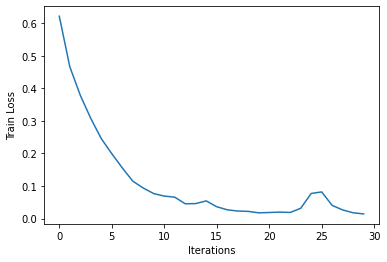

In [44]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Train Loss')

### Valid Loss 손실함수

Text(0, 0.5, 'Valid Loss')

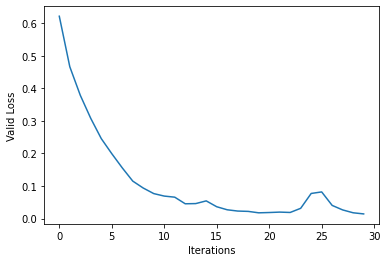

In [45]:
x = np.arange(len(valid_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Valid Loss')

### Valid Accuracy 함수

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

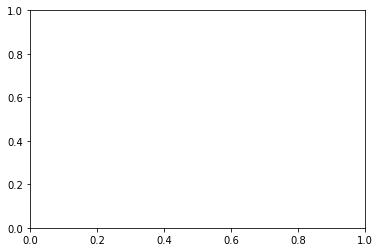

In [46]:
x = np.arange(len(valid_acc_list))
plt.plot(x, valid_acc_list, label='valid_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [77]:
# %load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [78]:
# %tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 327), started 0:10:25 ago. (Use '!kill 327' to kill it.)

In [79]:
# writer.close()

# 7. 모델 예측

In [47]:
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([32, 3, 299, 299]) torch.Size([32])


In [48]:
rnd_idx = 10
images[rnd_idx:rnd_idx+1].shape, labels[rnd_idx:rnd_idx+1] 

(torch.Size([1, 3, 299, 299]), tensor([0], device='cuda:0'))

In [49]:
img = images[rnd_idx:rnd_idx+1]
with torch.no_grad():
    model.eval() # 배치 정규화가 들어가면서 전방향 연산이 학습시와는 달라지므로 반드시 eval() 넣어야 함
    logit = model.forward(img)

pred = logit.max(dim=1)[1]
pred == labels[rnd_idx]

tensor([True], device='cuda:0')

In [50]:
pred, labels[rnd_idx] # 예측 0(hot-dog), 정답 0(hot-dog)

(tensor([0], device='cuda:0'), tensor(0, device='cuda:0'))

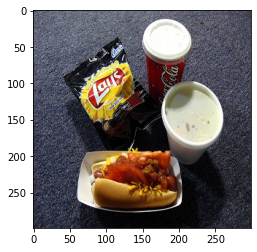

In [51]:
img = img.cpu()
plt.imshow(img[0].permute(1, 2, 0)) 

# 8. 모델 평가

In [52]:
def evaluation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0

    with torch.no_grad():
        model.eval()
        for images, labels in testloader: 
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images) 
            _, preds = torch.max(logits, 1) 
            correct = (preds == labels).sum()
      
            accuracy = correct / images.shape[0]
            loss = criterion(logits, labels) 
      
            test_accuracy += accuracy.item()
            test_loss += loss.item() 
        
    print('Test Loss : ', test_loss/len(testloader))
    print('Test Accuracy : ', test_accuracy/len(testloader))

In [53]:
evaluation(model, testloader, criterion)

Test Loss :  0.6965368751968656
Test Accuracy :  0.7395833333333334


# 9. 모델 저장

In [55]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [56]:
last_state_dict = torch.load('last_checkpoint.pth')
last_state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.4.weight', 'features.4.bias', 'features.5.weight', 'features.5.bias', 'features.5.running_mean', 'features.5.running_var', 'features.5.num_batches_tracked', 'features.8.weight', 'features.8.bias', 'features.9.weight', 'features.9.bias', 'features.9.running_mean', 'features.9.running_var', 'features.9.num_batches_tracked', 'features.11.weight', 'features.11.bias', 'features.12.weight', 'features.12.bias', 'features.12.running_mean', 'features.12.running_var', 'features.12.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.18.weight', 'features.18.bias', 'features.19.weight', 'features.19.bias', 'features.19.running_mean', 'features.19.running_var', 

In [57]:
last_model = AlexNet()
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [58]:
evaluation(last_model, testloader, criterion)

Test Loss :  0.78692738348391
Test Accuracy :  0.7317073170731707


In [59]:
best_state_dict = torch.load('best_checkpoint.pth')

In [60]:
best_model = AlexNet()
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [61]:
evaluation(best_model, testloader, criterion)

Test Loss :  0.755822773205071
Test Accuracy :  0.7210365853658537
